In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
%matplotlib inline

## PDX validation

In [4]:
''' Use the 'create_ExpData.py' code to generate pseudoraw counts and run limma voom normalisation to
get normalised counts'''

# read the normalised expression data
pdx_exp = pd.read_csv('/home/sreeramp/cancer_dependency_project/sreeram/PDX_tumorResponses/limma_normalised.csv',
                   header = 0, index_col = 0)
pdx_exp.head()

,X-1004,X-1008,X-1027,X-1095,X-1119,X-1156,X-1167,X-1169,X-1172,X-1173,...,X-5713,X-5717,X-5727,X-5739,X-5808,X-5959,X-5974,X-5975,X-6030,X-6047
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.705930,2.093958,-3.57929,-3.371175,-4.320349,3.005249,-3.480815,-2.036119,-4.510299,-9.736154,...,3.491189,-2.077142,3.329330,-9.758661,2.058393,2.892047,1.346397,1.760843,-4.327372,0.639591
A2M,-4.790338,7.626496,-9.64538,3.973614,-9.605751,7.281283,-9.923758,-3.810559,8.199078,-3.903264,...,10.483192,-3.031750,6.708868,-9.758661,9.544384,6.963622,2.757630,-9.799968,-9.753637,-1.144889
A2ML1,-9.648319,1.171302,-9.64538,-2.129286,-4.396298,-1.639646,-1.544380,9.470875,-9.795701,-1.208677,...,-2.591853,0.053458,-3.560306,-2.227279,-4.678695,-2.631304,-1.690420,3.119082,-0.224206,1.240464
A4GALT,-1.997268,1.037063,2.18236,0.713592,-9.605751,3.210545,-9.923758,6.197747,2.900614,-1.859637,...,-5.723559,5.977323,4.051752,2.409698,-3.822059,-1.878929,5.922268,-9.799968,-1.992086,3.990310
AAAS,4.592397,3.446065,5.08843,5.783282,5.005562,4.650691,4.229081,4.128350,4.776703,5.015442,...,4.538882,4.710969,4.179092,5.052061,4.902964,4.950781,4.886523,4.238180,4.439658,4.905143


In [5]:
dataset_path = "/home/sreeramp/cancer_dependency_project/sreeram/datasets/PDX_tumorSize_drugResponses.xlsx"
# exp_data = pd.read_excel(dataset_path, sheet_name="RNAseq_fpkm", header=0, index_col=0)
pdx_response_data = pd.read_excel(dataset_path, sheet_name="PCT raw data", header=0, index_col=0)

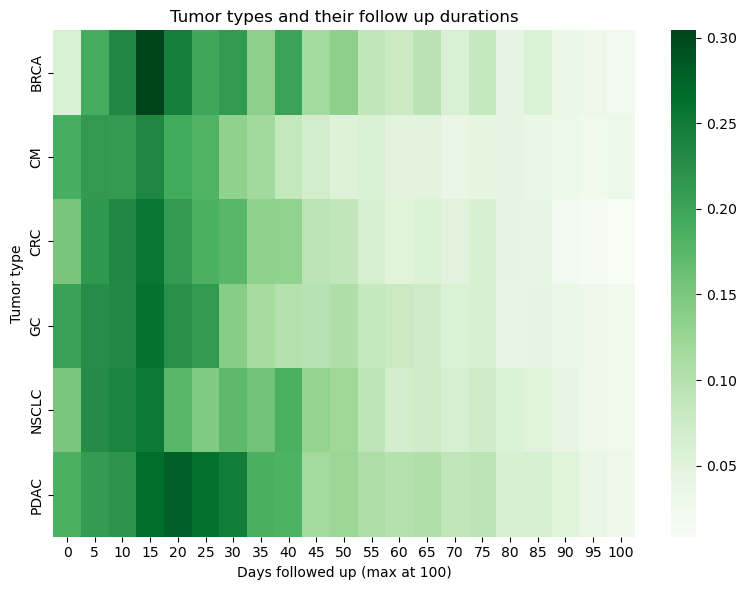

In [6]:
ct = pd.crosstab(pdx_response_data["Tumor Type"], pdx_response_data["Days Post T0"])
# ct = ct / ct.loc[:, 0]
ct_norm = ct.div(ct[0], axis=0)
ct_norm.drop(0, axis=1, inplace=True)
ct_norm.drop(ct_norm.columns[-1], axis=1, inplace=True)

# Define uniform follow-up days
uniform_days = np.arange(0, 101, 5)  # 0, 5, 10, ..., 100

# Reindex columns to these uniform days and interpolate
ct_interp = ct_norm.T  # transpose to make Days the index
ct_interp = ct_interp.reindex(uniform_days).interpolate(method='linear', limit_direction='both')

# (Optional) Rolling average smooth (window size = 3)
ct_smoothed = ct_interp.rolling(window=3, min_periods=1, center=True).mean()

# Transpose back: rows = tumor types, columns = Days
ct_final = ct_smoothed.T

# Plot heatmap
plt.figure(figsize = (8,6))
sns.heatmap(
    ct_final,
    cmap="Greens",          # white-to-green colormap
    linewidths=0,
    linecolor='gray',
    cbar=True,
    yticklabels=True       # hides row names
)

plt.xlabel("Days followed up (max at 100)")
plt.ylabel("Tumor type")              # optional: hides y-axis label
plt.title("Tumor types and their follow up durations")
plt.tight_layout()
plt.show()

#### As seen from above heatmap, many of the NSCLC samples were followed upto 20 days.

We now subset the data for erlotinib treated patients.

In [8]:
days_followup = list(range(0, 25, 5))
pdx_response_data = pdx_response_data.reset_index()
pdx_response_data["model_treatment"] = pdx_response_data["Model"].astype(str) + "_" + pdx_response_data["Treatment"]

# create a df for tumor volume difference over time
tumor_vol_shrinkage = pd.DataFrame(index = pdx_response_data["model_treatment"].unique(),
                                   columns = [f'T{i}' for i in days_followup])
# tumor_vol_shrinkage.head()
for model_treatment in list(pdx_response_data["model_treatment"].unique()):
  # print(model_treatment)
  model_data = pdx_response_data[pdx_response_data["model_treatment"] == model_treatment]
  # for 1st time point = 0
  if 0 in model_data["Days Post T0"]:
    tumor_vol_shrinkage.loc[model_treatment, "T0"] = model_data[model_data["Days Post T0"] == 0]["% TVol Difference"].values[0]
  for i, time_followup in enumerate(days_followup):
    if i != 0:
      # print(f"time:{time_followup}")
      if (model_data["Days Post T0"] < time_followup).any():
    # summarise based on time followup bins
        step_data = model_data[(model_data["Days Post T0"] != 0) & (model_data["Days Post T0"] > days_followup[i-1]) & (model_data["Days Post T0"] <= time_followup)]
        # print(step_data)
        tumor_vol_shrinkage.loc[model_treatment, f"T{time_followup}"] = np.mean(step_data["% TVol Difference"])

In [10]:
tumor_vol_shrinkage['Model'] = tumor_vol_shrinkage.index.str.split('_').str[0]
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model
X-007_BGJ398,0.0,191.8,293.6,396.5,NaN,X-007
X-007_BKM120,NaN,45.4,119.6,166.15,NaN,X-007
X-007_BYL719,NaN,187.0,294.0,303.7,NaN,X-007
X-007_BYL719 + HSP990,NaN,66.7,-11.7,6.1,33.45,X-007
X-007_BYL719 + LJM716,NaN,53.7,68.8,40.0,50.9,X-007


In [11]:
pdx_response_data.head()

,Model,Tumor Type,Treatment,Volume (mm3),body weight (g),Days Post T0,% TVol Difference,% BW Difference,model_treatment
0,X-007,GC,BGJ398,202.3,21.5,0,0.0,0.0,X-007_BGJ398
1,X-007,GC,BGJ398,590.3,23.0,4,191.8,7.0,X-007_BGJ398
2,X-007,GC,BGJ398,796.3,22.7,7,293.6,5.6,X-007_BGJ398
3,X-007,GC,BGJ398,1004.5,23.4,11,396.5,8.8,X-007_BGJ398
4,X-007,GC,BKM120,288.8,20.4,0,0.0,0.0,X-007_BKM120


In [12]:
pdx_response_data['Treatment'].value_counts()

Treatment
LEE011         3824
binimetinib    3786
BYL719         3475
BKM120         3385
CLR457         3363
               ... 
dacarbazine     331
erlotinib       325
LGH447          321
LDK378          270
LDE225          232
Name: count, Length: 62, dtype: int64

In [13]:
egfr_therapy = pdx_response_data[pdx_response_data['Treatment'] == 'erlotinib']
egfr_therapy.head()

,Model,Tumor Type,Treatment,Volume (mm3),body weight (g),Days Post T0,% TVol Difference,% BW Difference,model_treatment
11552,X-1156,NSCLC,erlotinib,241.4,26.1,0,0.0,0.0,X-1156_erlotinib
11553,X-1156,NSCLC,erlotinib,389.5,26.5,3,61.4,1.5,X-1156_erlotinib
11554,X-1156,NSCLC,erlotinib,729.3,25.3,7,202.1,-3.1,X-1156_erlotinib
11555,X-1156,NSCLC,erlotinib,733.3,23.6,10,203.8,-9.6,X-1156_erlotinib
11556,X-1156,NSCLC,erlotinib,687.5,26.8,13,184.8,2.7,X-1156_erlotinib


In [14]:
egfr_treated_pt = egfr_therapy['Model'].unique()
tumor_vol_shrinkage = tumor_vol_shrinkage[tumor_vol_shrinkage['Model'].isin(egfr_treated_pt)]
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model
X-1156_BGJ398,NaN,27.5,106.3,166.1,246.5,X-1156
X-1156_BKM120,NaN,24.7,173.6,194.1,422.75,X-1156
X-1156_BKM120 + binimetinib,NaN,52.1,60.6,111.7,130.0,X-1156
X-1156_BYL719 + LGH447,NaN,-4.4,43.95,65.2,127.35,X-1156
X-1156_BYL719 + LJM716,NaN,6.3,147.75,339.8,502.35,X-1156


In [15]:
tumor_vol_shrinkage['therapy'] = tumor_vol_shrinkage.index.str.split("_").str[1]
tumor_vol_shrinkage = tumor_vol_shrinkage[tumor_vol_shrinkage['therapy'] == 'erlotinib']
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,Model,therapy
X-1156_erlotinib,NaN,61.4,202.95,184.8,391.7,X-1156,erlotinib
X-1172_erlotinib,NaN,-0.6,74.0,172.05,NaN,X-1172,erlotinib
X-1189_erlotinib,NaN,10.9,-4.05,-5.6,-49.3,X-1189,erlotinib
X-1228_erlotinib,NaN,-53.6,-54.1,-44.1,-38.3,X-1228,erlotinib
X-1323_erlotinib,NaN,-18.6,-18.9,27.6,57.2,X-1323,erlotinib


In [16]:
tumor_vol_shrinkage.set_index('Model', inplace=True, drop = True)
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,therapy
Model,,,,,,
X-1156,NaN,61.4,202.95,184.8,391.7,erlotinib
X-1172,NaN,-0.6,74.0,172.05,NaN,erlotinib
X-1189,NaN,10.9,-4.05,-5.6,-49.3,erlotinib
X-1228,NaN,-53.6,-54.1,-44.1,-38.3,erlotinib
X-1323,NaN,-18.6,-18.9,27.6,57.2,erlotinib


In [17]:
common_samples = np.intersect1d(pdx_exp.columns, tumor_vol_shrinkage.index)
pdx_exp = pdx_exp[common_samples].T
tumor_vol_shrinkage = tumor_vol_shrinkage.loc[common_samples]
pdx_exp.head()

Gene,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X-1156,3.005249,7.281283,-1.639646,3.210545,4.650691,6.748086,2.435532,7.081956,5.601510,4.931941,...,4.558227,2.391692,-1.515199,0.603942,4.343536,3.205128,6.053045,6.192540,4.338046,6.400886
X-1172,-4.510299,8.199078,-9.795701,2.900614,4.776703,6.992010,3.444643,6.000871,5.484526,5.507972,...,4.580492,2.702899,0.757928,2.187649,6.097245,3.594871,5.025126,2.308570,5.360105,7.030090
X-1323,1.385048,2.055912,-2.658953,1.439174,3.821155,6.873149,2.658093,6.496390,10.675614,3.834200,...,4.350460,2.699867,-6.646014,-2.945574,4.466891,3.996425,5.619894,5.709141,6.412244,7.438736
X-1442,-4.503718,9.149474,-9.789121,-0.206038,5.137222,7.180322,4.100859,5.800267,5.486677,4.103327,...,5.167755,2.745912,-2.001218,0.855637,4.287445,2.956764,5.463212,4.122927,5.695482,6.460715
X-1499,1.052644,3.324142,-1.561348,3.703661,5.532454,5.966648,1.564468,6.064549,7.054947,5.034771,...,4.656377,3.382977,-1.131723,0.741690,4.285739,4.397067,5.701498,5.039452,4.644667,6.583062


#### For the PDX dataset, L=30 gave the best results

In [18]:
gene_weights = pd.read_csv('../Data/latent30_gene_weights.csv',
                           header = 0, index_col = 0)
gene_weights.head()

,ic50_weight,deps_weight,combined_weight,scaled_combined_weight
EGFR,0.360948,0.005513,2.332825,1.599903
KLK7,-0.094738,0.000341,-0.578267,-0.389472
SLC4A2,0.283241,-0.004950,1.775886,1.219304
PKMP1,0.386586,-0.010572,2.393172,1.641143
TINAGL1,0.087799,0.001058,0.579290,0.401576


In [19]:
common_genes = np.intersect1d(gene_weights.index, pdx_exp.columns)
print(len(common_genes))

131


In [20]:
weighted_df = pd.DataFrame(index = pdx_exp.index, columns = common_genes)
for gene in common_genes:
  g_weight = gene_weights.loc[gene, 'scaled_combined_weight']
  weighted_df[gene] = pdx_exp[gene] * g_weight
  
weighted_df.head()

,ACE2,ADAP1,AGPAT1,AGR2,AKT1S1,ALS2CL,ANKRD52,ANKS3,ANO1,BTBD19,...,TNK1,TNS4,TSPAN1,TUBB3,TXNDC15,UPK2,UPK3B,WFS1,ZNF668,ZNF750
X-1156,1.109995,5.178126,-8.059616,0.917855,8.554780,1.121371,0.374510,-1.136350,1.627558,0.312073,...,-0.511368,-0.446089,0.272740,3.960458,-3.147449,-7.288847,-2.589106,6.998383,0.078118,-1.576593
X-1172,0.022361,3.776295,-8.336472,1.317849,8.285291,0.534245,0.493949,-0.856189,-0.398875,-0.310752,...,-0.800811,5.196532,0.214786,2.271364,-2.886373,-5.433834,-2.060552,6.065759,0.130760,-1.755470
X-1323,-0.532865,5.926129,-7.369263,0.940772,6.524098,1.573349,0.522464,-1.031007,1.940870,-0.355252,...,-1.439598,-3.620674,-0.440069,4.173522,-2.026776,-1.834327,9.328709,5.002944,0.140039,0.206301
X-1442,-2.282623,7.583191,-9.594029,0.964012,8.046020,2.184616,0.500398,-0.966817,4.329471,-0.350832,...,-1.111426,-4.204348,-0.166728,0.777729,-2.824520,-15.073320,-4.671344,4.713357,0.141203,-1.568426
X-1499,1.132458,1.121912,-11.066827,0.072335,6.763767,1.555414,0.592963,-0.900069,1.102703,-1.056417,...,-0.331821,2.313073,0.090559,5.743317,-2.552585,1.812928,-1.248194,6.144318,0.081603,-0.269433


In [21]:
pdx_scores = weighted_df.sum(axis = 1)

In [ ]:
tumor_vol_shrinkage['pdx_score'] = pdx_scores

,T0,T5,T10,T15,T20,therapy,pdx_score
Model,,,,,,,
X-1156,NaN,61.4,202.95,184.8,391.7,erlotinib,6.295068
X-1172,NaN,-0.6,74.0,172.05,NaN,erlotinib,18.600258
X-1323,NaN,-18.6,-18.9,27.6,57.2,erlotinib,33.944110
X-1442,NaN,-10.4,-3.0,13.6,NaN,erlotinib,23.971205
X-1499,NaN,10.6,93.2,302.45,NaN,erlotinib,-9.162663


In [23]:
tumor_vol_shrinkage['score_cat'] = np.where(tumor_vol_shrinkage['pdx_score'] > np.median(tumor_vol_shrinkage['pdx_score']),
                                            'high score', 'low score')
tumor_vol_shrinkage.head()

,T0,T5,T10,T15,T20,therapy,pdx_score,score_cat
Model,,,,,,,,
X-1156,NaN,61.4,202.95,184.8,391.7,erlotinib,6.295068,low score
X-1172,NaN,-0.6,74.0,172.05,NaN,erlotinib,18.600258,high score
X-1323,NaN,-18.6,-18.9,27.6,57.2,erlotinib,33.944110,high score
X-1442,NaN,-10.4,-3.0,13.6,NaN,erlotinib,23.971205,high score
X-1499,NaN,10.6,93.2,302.45,NaN,erlotinib,-9.162663,low score


In [24]:
long_df_data = pd.melt(
    tumor_vol_shrinkage.reset_index(),  # ensure 'pdx_id' is a column, not index
    id_vars=['pdx_score', 'score_cat'],
    value_vars=['T15'],
    # var_name='timepoint',
    value_name='%TVC'
)
long_df_data.dropna(inplace=True)
long_df_data['%TVC'] = pd.to_numeric(long_df_data['%TVC'], errors='coerce')
long_df_data.head()

,pdx_score,score_cat,variable,%TVC
0,6.295068,low score,T15,184.80
1,18.600258,high score,T15,172.05
2,33.944110,high score,T15,27.60
3,23.971205,high score,T15,13.60
4,-9.162663,low score,T15,302.45


In [26]:
group_high = long_df_data.loc[long_df_data['score_cat'] == 'high score', '%TVC'].dropna()
group_low  = long_df_data.loc[long_df_data['score_cat'] == 'low score',  '%TVC'].dropna()
ks_stat, p_value = mannwhitneyu(group_high, group_low, alternative='less')

print(f"KS Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4e}")

KS Statistic: 45.0000
P-value: 2.5176e-01


<Axes: xlabel='score_cat', ylabel='%TVC'>

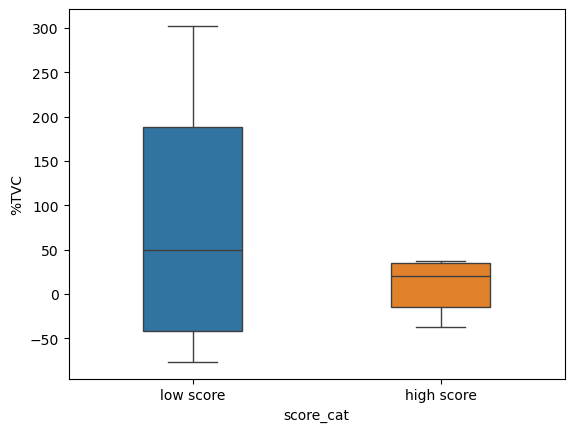

In [27]:
sns.boxplot(
    data=long_df_data,
    x="score_cat", y="%TVC",
    hue="score_cat", 
    showfliers=False,
    width=0.4  # <-- The main change here
)

## Tahoe Validation

In [32]:
'''Run voom normalisation for both drug and DMSO data separately'''

voom_pb_data = pd.read_csv("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/Tahoe_analysis/Erlotinib_vs_DMSO_voom_normalised_tahoe.csv")
dmso_only = voom_pb_data[voom_pb_data['DRUG'] == 'DMSO'].copy()
dmso_only.set_index('CELLLINE', inplace=True)
dmso_only.drop(columns=['DRUG'], inplace=True)

dmso_only.index = dmso_only.index.str.replace(' ', '')

dmso_only.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1ORF112,FGR,CFH,FUCA2,GCLC,NFYA,...,POLGARF,ENSG00000291308,LY6S,ENSG00000291310,ENSG00000291312,ENSG00000291313,ENSG00000291314,ENSG00000291315,TMEM276ZFTRAF1,TMEM276
CELLLINE,,,,,,,,,,,,,,,,,,,,,
A-172,0.646315,-2.813117,6.441912,3.756739,4.808935,-0.491189,1.941771,4.764312,5.169877,5.361809,...,-0.491189,-2.813117,-2.813117,-2.813117,-2.813117,-2.813117,-2.813117,-2.813117,-1.228154,1.579201
A-427,3.317673,-3.368827,6.861193,3.791044,5.069965,-3.368827,0.090604,5.564863,5.558951,5.914261,...,-1.046899,-3.368827,-3.368827,-3.368827,-3.368827,-3.368827,-3.368827,-3.368827,-1.783865,1.988725
A498,3.200580,-4.267026,7.546355,3.232820,4.422972,-4.267026,6.195477,5.492863,6.794346,5.570602,...,-1.945098,-4.267026,-2.682063,-4.267026,-4.267026,-4.267026,-4.267026,-4.267026,-1.097101,2.142365
A549,3.246793,-3.196150,6.703207,2.585209,4.425902,-1.611188,2.585209,4.775393,6.718235,5.121262,...,-0.874222,-3.196150,-3.196150,-3.196150,-3.196150,-3.196150,-3.196150,-3.196150,-0.874222,2.585209
AN3CA,5.156940,-0.269325,6.444920,2.538030,4.485562,-0.269325,2.538030,5.920499,6.949843,6.890546,...,1.315637,-0.269325,-0.269325,-0.269325,-0.269325,-0.269325,-0.269325,-0.269325,-0.269325,2.538030


In [34]:
gene_weights = pd.read_csv('../Data/L40_gene_weights_final.csv', header = 0, index_col = 0)
common_genes = np.intersect1d(dmso_only.columns, gene_weights.index)
print(len(common_genes))

197


In [35]:
dmso_voom_f = dmso_only[common_genes]
dmso_voom_f.shape

(50, 197)

In [36]:
weighted_df = pd.DataFrame(index = dmso_voom_f.index, columns = common_genes)
for gene in common_genes:
  g_weight = gene_weights.loc[gene, 'scaled_combined_weight']
  weighted_df[gene] = dmso_voom_f[gene] * g_weight
  
weighted_df.head()

,ACE2,ADAP1,AGPAT1,AGR2,AKT1S1,ALS2CL,ANKRD52,ANKS3,ANO1,ANXA8,...,UGT1A8,UPK2,UPK3B,VCAM1,WFS1,YWHABP2,ZNF385C,ZNF668,ZNF750,ZNF804A
CELLLINE,,,,,,,,,,,,,,,,,,,,,
A-172,0.019004,-0.405937,-6.517026,-1.154733,3.044212,-0.539475,0.903049,-3.375502,2.054816,-0.761978,...,-0.241403,-0.002839,0.002815,-0.915981,4.159774,0.570676,-0.087240,-0.706476,0.002671,0.214912
A-427,0.130338,-0.438185,-7.917192,-0.899238,3.235976,-0.447315,0.898283,-3.188197,1.883469,0.390106,...,-0.205776,0.504327,0.511563,0.041170,2.654750,0.683409,0.463289,-1.029543,0.003053,0.411897
A498,0.056474,-0.145290,-6.390107,-0.862111,3.009851,-0.283630,0.991620,-3.728634,1.740429,1.590022,...,-0.003754,0.240395,-0.812966,-1.837000,2.863690,0.865620,-0.259253,-1.082268,0.004391,0.103279
A549,0.033823,-0.165274,-5.556467,-1.331794,2.977062,-0.380721,0.807542,-3.456838,1.978474,-0.098107,...,-0.171835,1.220189,-0.648635,-0.054496,1.534969,0.648380,0.295159,-0.808636,0.004753,0.102359
AN3CA,-0.050901,-0.288473,-7.745861,-1.393395,2.263458,0.044665,0.909534,-3.352509,2.830142,0.100359,...,-0.052938,1.011424,-1.002997,-0.272321,3.333658,0.054636,-0.047835,-1.009990,-0.007153,0.214323


In [39]:
tahoe_benefit_scores = weighted_df.sum(axis = 1)

In [40]:
tahoe_score_df = pd.DataFrame(index = dmso_voom_f.index)
tahoe_score_df['benefit_score'] = tahoe_benefit_scores
tahoe_score_df['score_cat'] = np.where(tahoe_score_df['benefit_score'] > np.median(tahoe_score_df['benefit_score']),
                                            'high score', 'low score')
tahoe_score_df.head()

,benefit_score,score_cat
CELLLINE,,
A-172,0.935276,high score
A-427,5.718021,high score
A498,-8.907291,low score
A549,-1.503690,low score
AN3CA,-1.177889,low score


#### Given the above scores, compute the transcriptome shift

In [41]:
erlotinib_pb = pd.read_csv('../Data/tahoe_erlotinib_pseudobulk.csv', header = 0, index_col=0)
erlotinib_pb.head()

,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2ML1-AS1,A2MP1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
pb_id,,,,,,,,,,,,,,,,,,,,,
plate7_A-172,112.0,56.0,81.0,0.0,3.0,2.0,7.0,18.0,0.0,19.0,...,62.0,14.0,19.0,19.0,384.0,63.0,268.0,108.0,301.0,218.0
plate7_A-427,57.0,35.0,29.0,1.0,4.0,1.0,20.0,31.0,0.0,6.0,...,111.0,29.0,11.0,27.0,436.0,194.0,297.0,93.0,271.0,414.0
plate7_A498,265.0,3.0,6.0,11.0,8.0,7.0,12.0,36.0,0.0,126.0,...,196.0,71.0,20.0,34.0,524.0,220.0,335.0,420.0,918.0,927.0
plate7_A549,69.0,13.0,33.0,0.0,1.0,3.0,11.0,25.0,0.0,25.0,...,116.0,16.0,4.0,20.0,211.0,57.0,194.0,100.0,435.0,272.0
plate7_AN3 CA,20.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,16.0,7.0,3.0,4.0,31.0,0.0,38.0,22.0,44.0,73.0


In [42]:
metadata = pd.DataFrame(index = erlotinib_pb.index)
metadata['plate_id'] = erlotinib_pb.index.str.split('_').str[0]
metadata['cell_line'] = erlotinib_pb.index.str.split('_').str[1]

In [43]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# If needed, import R libraries
ro.r('library(limma)')
ro.r('library(edgeR)')

array(['edgeR', 'limma', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [ ]:
# Activate conversion
pandas2ri.activate()

# Pass data from Python to R
ro.globalenv['counts'] = pandas2ri.py2rpy(erlotinib_pb.T)
ro.globalenv['metadata'] = pandas2ri.py2rpy(metadata)

# Run R code
ro.r('''
library(edgeR)
library(limma)
dge <- DGEList(counts = counts)
dge <- calcNormFactors(dge)
design <- model.matrix(~ 0 + factor(metadata$plate_id) + factor(metadata$cell_line))
v <- voom(dge, design, plot=FALSE)
voom_expr <- v$E
''')

# Pull voom_expr back to Python
with localconverter(ro.default_converter + pandas2ri.converter):
    voom_expr = ro.conversion.rpy2py(ro.r('as.data.frame(voom_expr)'))


In [49]:
voom_expr.head()

,plate7_A-172,plate7_A-427,plate7_A498,plate7_A549,plate7_AN3 CA,plate7_AsPC-1,plate7_BT-474,plate7_C-33 A,plate7_C32,plate7_CFPAC-1,...,plate9_SK-MEL-2,plate9_SNU-1,plate9_SNU-423,plate9_SW 1088,plate9_SW 1271,plate9_SW 900,plate9_SW1417,plate9_SW48,plate9_SW480,plate9_hTERT-HPNE
7SK,5.197652,3.950309,5.275292,4.476051,5.343776,6.356873,6.411348,4.995484,7.245747,5.976715,...,7.147856,6.905985,6.667334,6.915659,6.594962,7.033103,7.377573,6.833961,5.900886,6.799829
A1BG,4.204050,3.254566,-0.969922,2.111997,1.571186,-2.209181,0.345259,3.356583,1.021209,-1.372013,...,1.902852,-0.609715,-1.281033,3.215219,3.631487,1.699202,-0.325177,1.656043,-1.101367,3.161228
A1BG-AS1,4.732599,2.987462,-0.076837,3.423199,1.571186,-0.624218,1.567651,3.356583,3.405873,-0.149621,...,3.983772,0.975248,-1.281033,3.215219,1.309559,2.921594,0.411789,-0.665885,-1.838332,3.161228
A1CF,-2.616129,-1.310219,0.746285,-2.642890,-0.013776,4.733334,1.082224,1.034655,-2.148716,-0.635048,...,-0.212626,-0.609715,-1.281033,3.215219,1.309559,0.114240,1.259786,0.919078,3.234917,2.509151
A2M,0.191226,0.274744,0.310186,-1.057928,-0.013776,0.112747,0.345259,1.686731,8.472420,-0.635048,...,5.950605,-0.609715,2.178398,3.215219,2.894522,0.114240,1.549293,2.793547,0.036137,-0.298203


In [50]:
erlotinib_pb_voom = voom_expr.T

In [51]:
erlotinib_pb_voom.to_csv('../Data/erlotinib_tahoe_voom.csv', index=True)

In [52]:
plate_ids = ['plate7', 'plate8', 'plate9']
conc_cat = ['0.05', '0.5', '5']
plate_conc_map = dict(zip(plate_ids, conc_cat))
plate_conc_map

{'plate7': '0.05', 'plate8': '0.5', 'plate9': '5'}

In [53]:
dmso_scaled = (dmso_only - dmso_only.mean()) / dmso_only.std()
common_genes2 = list(set(erlotinib_pb_voom.columns) & set(dmso_scaled.columns))
dmso_scaled_exp = dmso_scaled[common_genes2]
erlotinib_pb_voom = erlotinib_pb_voom[common_genes2]
dmso_scaled_exp.shape, erlotinib_pb_voom.shape

((50, 17667), (150, 17667))

In [54]:
delta_expression_df = pd.DataFrame(index=tahoe_score_df.index, columns=plate_ids)
for plate_name in plate_ids:
  conc = plate_conc_map[plate_name]
  mask = erlotinib_pb_voom.index.str.contains(plate_name)
  drug_df = erlotinib_pb_voom.loc[mask]
  drug_df = (drug_df - drug_df.mean()) / drug_df.std()
  drug_df['cell_line'] = drug_df.index.str.split('_').str[1]
  drug_df.set_index('cell_line', inplace=True, drop = True)
  print(drug_df.shape)
  dmso_scaled_exp = dmso_scaled_exp[drug_df.columns]
  delta_expression = drug_df.values - dmso_scaled_exp.values
  response_strengths = np.linalg.norm(delta_expression, axis=1)
  delta_expression_df[plate_name] = response_strengths
delta_expression_df.head()

(50, 17667)
(50, 17667)
(50, 17667)


,plate7,plate8,plate9
CELLLINE,,,
A-172,69.270840,66.915592,78.420289
A-427,65.228140,60.950155,80.304270
A498,55.620062,47.814402,74.807102
A549,66.708539,63.496308,76.731203
AN3CA,123.700175,122.643297,133.199938


In [55]:
merged_tahoe_df = pd.concat([tahoe_score_df, delta_expression_df], axis = 1)

In [56]:
merged_tahoe_df.head()

,benefit_score,score_cat,plate7,plate8,plate9
CELLLINE,,,,,
A-172,0.935276,high score,69.270840,66.915592,78.420289
A-427,5.718021,high score,65.228140,60.950155,80.304270
A498,-8.907291,low score,55.620062,47.814402,74.807102
A549,-1.503690,low score,66.708539,63.496308,76.731203
AN3CA,-1.177889,low score,123.700175,122.643297,133.199938


In [57]:
merged_tahoe_df_long = pd.melt(
    merged_tahoe_df.reset_index(), 
    id_vars=['CELLLINE', 'benefit_score', 'score_cat'], 
    var_name='plate', 
    value_name='response_strength'
)

In [58]:
merged_tahoe_df_long.head()

,CELLLINE,benefit_score,score_cat,plate,response_strength
0,A-172,0.935276,high score,plate7,69.270840
1,A-427,5.718021,high score,plate7,65.228140
2,A498,-8.907291,low score,plate7,55.620062
3,A549,-1.503690,low score,plate7,66.708539
4,AN3CA,-1.177889,low score,plate7,123.700175


In [59]:
merged_tahoe_df_long['log_val'] = np.log10(merged_tahoe_df_long['response_strength'])

In [60]:
merged_tahoe_df_long.head()

,CELLLINE,benefit_score,score_cat,plate,response_strength,log_val
0,A-172,0.935276,high score,plate7,69.270840,1.840550
1,A-427,5.718021,high score,plate7,65.228140,1.814435
2,A498,-8.907291,low score,plate7,55.620062,1.745231
3,A549,-1.503690,low score,plate7,66.708539,1.824181
4,AN3CA,-1.177889,low score,plate7,123.700175,2.092370


In [61]:
merged_tahoe_df_long['plate'].value_counts()

plate
plate7    50
plate8    50
plate9    50
Name: count, dtype: int64

<Axes: xlabel='plate', ylabel='log_val'>

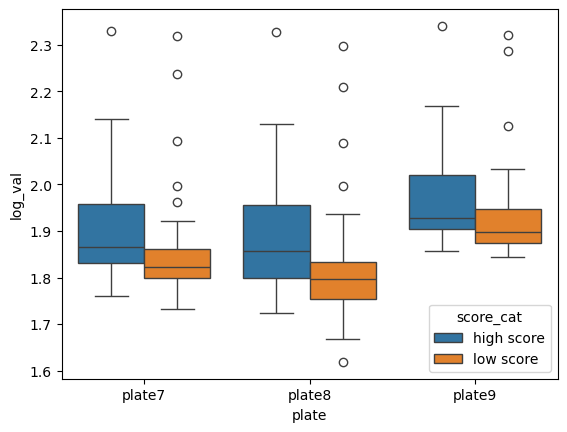

In [62]:
sns.boxplot(data=merged_tahoe_df_long, x = 'plate', y = 'log_val', hue = 'score_cat')

In [67]:
ro.globalenv['d'] = pandas2ri.py2rpy(merged_tahoe_df_long)

ro.r('''
library(dplyr)
ks_results <- d %>%
  group_by(plate) %>%
  summarise(
    ks_statistic = ks.test(log_val[score_cat == "low score"],
        log_val[score_cat == "high score"])$statistic,
    p_value = ks.test(log_val[score_cat == "low score"],
        log_val[score_cat == "high score"])$p.value
  )
''')

with localconverter(ro.default_converter + pandas2ri.converter):
    ks_res = ro.conversion.rpy2py(ro.r('as.data.frame(ks_results)'))
ks_res

,plate,ks_statistic,p_value
1,plate7,0.36,0.077898
2,plate8,0.40,0.035611
3,plate9,0.32,0.155760


#### The p-values are different in R implementation of KS test.